In [ ]:
#| default_exp vq_stoks

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import sys
import time
import torch
import torchaudio

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import fastprogress
import numpy as np
import pylab as plt
import pandas as pd
import random

import whisper
from huggingface_hub import hf_hub_download
from fastcore.basics import store_attr

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import webdataset as wds
from whisperspeech import utils

from vector_quantize_pytorch import ResidualVQ

from fastcore.script import *

In [ ]:
from whisperspeech import wh_transcribe
import IPython

# Distill Whisper with a VQ bottleneck

Multi-GPU training example:
    
    python -m whisperspeech.train_multi \
        --task "vq_stoks base.en-2d-512c-dim64" --batch-size 32 --epochs 4 \
        --input-dir "librilight/ librilight-preproc/ --samples 250000" \
        --tunables="--rope --mask_embs --downsample_mean"

## Prepare the dataset

In [ ]:
shards = [str(x) for x in Path('/data/whisperspeech-wds/').glob('librilight-*.tar')]

In [ ]:
ds = wds.WebDataset(shards, shardshuffle=True)

In [ ]:
#| exporti
def merge_in(dataset_fun):
    """Merge a dataset into the current one returning samples with the union of keys. Pass in a function
    that takes a URL of a sample and returns a dataset for it (called everytime the URL changes).
    
    It requires (and validates) that both datasets have the same ordering of keys so you have
    to use it before any sample shuffling. Shard shuffling is ok.
    """
    def merge_loop(main_samples):
        #print("new merge loop:", dataset_fun)
        merged_samples = None
        cur_url = None
        i = None
        for s in main_samples:
            url = s['__url__']
            if url != cur_url:
                # this will open a new file when we get the first sample with a new __url__
                merged_samples = iter(dataset_fun(url))
                cur_url = url
            try:
                merge_s = next(merged_samples)
            except StopIteration:
                # if the original shard got repeated we won't observe a __url__ change
                # in this case restart the dataset from the beginning
                merged_samples = iter(dataset_fun(url))
                merge_s = next(merged_samples)
            assert merge_s['__key__'] == s['__key__'], f"sample keys don't match: {merge_s['__key__']}, {s['__key__']} in file {s['__url__']}"
            news = {}
            news.update(merge_s)
            news.update(s)
            yield news
    return merge_loop

In [ ]:
#| exporti
def derived_dataset(kind, key='audio'):
    def deriver(url):
        url = str(Path(url).parent/(Path(url).name.replace(key, kind) + ".gz"))
        return wds.WebDataset(
            wds.SimpleShardList([url])
        ).decode()
    return deriver

In [ ]:
ds2 = ds.compose(
    wds.decode(wds.torch_audio),
    wds.select(lambda x: 'wav' in x or 'flac' in x or 'mp3' in x or 'ogg' in x), # skip samples without audio
    wds.rename(audio="flac;mp3;wav;ogg"),
    merge_in(derived_dataset('/data/whisperspeech-processed-wds/', 'vad')),
    wds.map_dict(**{"vad.npy":wh_transcribe.chunk_merger}),
    wh_transcribe.split_to_chunks,
    merge_in(derived_dataset('/data/whisperspeech-processed-wds/', 'base.en-txt')),
    wds.shuffle(),
    wds.select(lambda x: x['i'] != 0 and x['i'] != x['imax']),
)

In [ ]:
vad_shards = [str(x) for x in Path('/data/whisperspeech-processed-wds/').glob('*-large-6454-vad-*.tar.gz')]

In [ ]:
ds = wds.WebDataset(vad_shards).decode().map_dict(**{'vad.npy':wh_transcribe.chunk_merger})

In [ ]:
chunks = [len(x['vad.npy'][1:-1]) for x in progress_bar(ds, total='noinfer')]

In [ ]:
sum(chunks)

203078

In [ ]:
for x in progress_bar(ds2, total=5):
    IPython.display.display(IPython.display.Markdown(f"## {x['__key__']} from {x['__url__']}\n{x['txt']}"))
    IPython.display.display(IPython.display.Audio(x['samples'], rate=16000))

## large/6454/kaffirkangarooklondiketales_1611_librivox_64kb_mp3/kaffirkangaroo_03_leavitt_64kb_006 from /data/whisperspeech-wds/librilight-large-6454-flac-000007.tar
Physically I was incapable of complying with the command, and mentally I had not the slightest intention of departing. In an outhouse devoted to storing melees, sheepskins, and harness, an old man was sitting on the doorstep, compounding a mixture which I recognized as a sheep remedy.

## large/6454/kaffirkangarooklondiketales_1611_librivox_64kb_mp3/kaffirkangaroo_03_leavitt_64kb_009 from /data/whisperspeech-wds/librilight-large-6454-flac-000007.tar
The following day I was the most surprised man in South Africa when I learned that my preparation was working a marvelous cure. I was invited to remain with the bore the balance of the season as an honoured guest. Day after day I tramped the hills, returning at night as wise and as rich as when I set out. There were unmistakable indications that gold should be found in the vicinity, but the stubborn fact remained that I could not find it.

## large/6454/kaffirkangarooklondiketales_1611_librivox_64kb_mp3/kaffirkangaroo_03_leavitt_64kb_001 from /data/whisperspeech-wds/librilight-large-6454-flac-000007.tar
I was one of the first prospectors in the Transvaal to search for gold and a precious dance it led me. At that time, but few Englishmen had ventured into the Boer country, and such was the jealousy with which they were regarded that it was impossible to secure any information which would assist in the search. Footsoir and weary, I tramped from farm to farm, content

## large/6454/kaffirkangarooklondiketales_1611_librivox_64kb_mp3/kaffirkangaroo_03_leavitt_64kb_032 from /data/whisperspeech-wds/librilight-large-6454-flac-000007.tar
Dead, more than twenty years. In fact, before I was married and came to live here, for he was my husband's father. Did you know him? Yes, but I was only a little girl at the time. Why have the clothes been kept?

## large/6454/kaffirkangarooklondiketales_1611_librivox_64kb_mp3/kaffirkangaroo_03_leavitt_64kb_004 from /data/whisperspeech-wds/librilight-large-6454-flac-000007.tar
Fortunately, I had acquired some knowledge of sheep in Australia else I believe that I should have starved. When all else failed, I became a sheep doctor and then did a compound whose virtues would have done credit to the most widely advertised path and medicine nostrum.

In [ ]:
#| exporti
def add_masks(samples):
    for s in samples:
        seconds = s['tend'] - s['tstart']
        # a mask (downsampled to the Whisper encoder token rate of 50/s) is used
        # to teach the model the concept of padding
        # this let's us decode shorter sequences later
        mask = torch.zeros(30*16000//320, dtype=torch.bool)
        mask[:int(seconds * 16000) // 320] = 1
        s['mask'] = mask
        yield s

def tokenize_text(samples, ttoks_size=200, model="base.en", language="en"):
    multilingual = not model.endswith(".en")
    tokenizer = whisper.tokenizer.get_tokenizer(multilingual, language=language, task="transcribe")
    for s in samples:
        ttoks = tokenizer.encode(s['txt'])
        tokens = list(tokenizer.sot_sequence) + ttoks
        rpad = ttoks_size - len(tokens)
        s['in_ttoks'] = F.pad(torch.tensor(tokens), (0, rpad), value=tokenizer.eot)
        s['out_ttoks'] = F.pad(torch.tensor(tokens[1:] + [tokenizer.eot]), (0, rpad), value=-100)
        yield s

In [ ]:
ds3 = ds2.compose(
    add_masks,
    tokenize_text,
    wds.to_tuple('samples', 'mask', 'in_ttoks', 'out_ttoks')
)

In [ ]:
for x in ds3: break
x

(tensor([0.0043, 0.0102, 0.0163,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([50257,  3152,   257, 44823,  3154,  1589,    11,   484,   673,  1144,
           572,   503,   286,  2837,   290,   706,  2063,   281,  1711,   338,
          1057,    11,   262, 39535, 21067,   373,   625,   262,  2318,   290,
           287,  5897, 10150,    13,  1119,  2582, 40424,   510,   262, 27913,
          4608,   284, 47251,   290,  1043,   257,  1588,  1426,   325,   286,
          4684, 13384,  3492,   284, 17655,   511, 15892,    13, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
       

In [ ]:
ds3 = ds2.compose(
    add_masks,
    lambda x: tokenize_text(x, model='medium', language='en'),
    wds.to_tuple('samples', 'mask', 'in_ttoks', 'out_ttoks')
)

In [ ]:
for x in ds3: break
x

(tensor([0.0013, 0.0010, 0.0011,  ..., 0.0000, 0.0000, 0.0000]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([50258, 50259, 50359,    32,  1326,  1270,  3931,   382,   613,    11,
         11672,   293, 37632, 13809,    11,   576,  1319,   264,  1851,   295,
           264,  1002,    11,   293,  1939,   576,   572,   544,  1643,   281,
         18071,   264,  1164,   295,  3687,    11,   420,  1497,   554,  1952,
          6018,    11,   813,   264,  1974,  5010,   295,   721,    11,   689,
           264,  7700,   366,  4054,   293,  7006,   293, 14154,   292,    13,
          2188,  1359, 17431,  2212,   281,  3511,   328,  3780,   311,  3567,
           294,   702,  1536,  6717,  1062,   362, 16424,   796,   666,   257,
          5403, 14763,    13, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       

In [ ]:
#| exporti
def load_dataset(
        shard_spec:str,
        proc_dataset_path:Path, # processed VAD and txt files
        samples:int,            # set the per-GPU sample count
        txt_label:str="base.en-txt", # the label of the files containing transcriptions
        model:str="base.en",
        key:str="flac",
        language:str=None,
        validation:bool=False,    
    ):
    from . import wh_transcribe
    shards = utils.shard_glob(shard_spec)
    
    if not language and model.endswith('en'): language = 'en'
    assert language, "please provide the dataset language for multilang models"
    
    same_on_all_nodes = lambda urls: urls # will only be used for validation
    ds = wds.WebDataset(shards, resampled=not validation, nodesplitter=same_on_all_nodes).compose(
        wds.decode(wds.torch_audio),
        wds.select(lambda x: 'wav' in x or 'flac' in x or 'mp3' in x or 'ogg' in x), # skip samples without audio
        wds.rename(audio="flac;mp3;wav;ogg"),
        merge_in(derived_dataset(proc_dataset_path, 'vad', key=key)),
        wds.map_dict(**{"vad.npy":wh_transcribe.chunk_merger}),
        wh_transcribe.split_to_chunks,
        utils.resampler(16000, 'samples_16k'),
        merge_in(derived_dataset(proc_dataset_path, txt_label, key=key)),
    )
    if 'librilight' in shards[0]:
        ds = ds.compose(
            # drop the first and last segment because they tend to be inaccurate
            # (the transcriptions don't have the "LibriVox" headers and "end of chapter" suffixes)
            wds.select(lambda x: x['i'] != 0 and x['i'] != x['imax']),
        )
    ds = ds.compose(
        add_masks,
        lambda x: tokenize_text(x, model=model, language=language),
        wds.to_tuple('samples_16k', 'mask', 'in_ttoks', 'out_ttoks'),
        wds.batched(32),
    )
    ds.total_samples = samples
    
    return ds

In [ ]:
train_ds = load_dataset('librilight-wds/librilight-small-flac-000000-s0*.tar', 'librilight-preproc-wds/', samples=2500 * 32)

In [ ]:
val_ds = load_dataset('librilight-wds/librilight-small-flac-000000-s11.tar', 'librilight-preproc-wds/', samples=500)

In [ ]:
for x in progress_bar(wds.WebLoader(train_ds, num_workers=16, batch_size=None), total='noinfer'): pass

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 for x in progress_bar(wds.WebLoader(train_ds, num_workers=16, batch_size=None), total='n     │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:41 in __iter__              │
│                                                                                                  │
│    38 │   def __iter__(self):                                                                    │
│    39 │   │   if self.total != 0: self.update(0)                                                 │
│    40 │   │   try:                                                                               │
│ ❱  41 │   │   │   for i,o in enumerate(self.gen):                                                │
│    42 │   │   │   │   if self.total and i >= self.total: break                                   │
│    43 │   │   │   │   yield o                                                                    │
│    44 │   │   │   │   self.update(i+1)                                                           │
│                                                                                                  │
│ /root/workspace/webdataset/webdataset/pipeline.py:64 in iterator                                 │
│                                                                                                  │
│    61 │   def iterator(self):                                                                    │
│    62 │   │   """Create an iterator through the entire dataset, using the given number of repe   │
│    63 │   │   for i in range(self.repetitions):                                                  │
│ ❱  64 │   │   │   for sample in self.iterator1():                                                │
│    65 │   │   │   │   yield sample                                                               │
│    66 │                                                                                          │
│    67 │   def __iter__(self):                                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:633 in __next__           │
│                                                                                                  │
│    630 │   │   │   if self._sampler_iter is None:                                                │
│    631 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    632 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  633 │   │   │   data = self._next_data()                                                      │
│    634 │   │   │   self._num_yielded += 1                                                        │
│    635 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    636 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1328 in _next_data        │
│                                                                                                  │
│   1325 │   │   │   │   return self._process_data(data)                                           │
│   1326 │   │   │                                           

In [ ]:
for x in train_ds:
    print(x[3])
    break

tensor([[  464,  7664,   286,  ...,  -100,  -100,  -100],
        [ 2953,   717,   612,  ...,  -100,  -100,  -100],
        [25383,   339,   587,  ...,  -100,  -100,  -100],
        ...,
        [  392,   340,   880,  ...,  -100,  -100,  -100],
        [  464, 31526, 11416,  ...,  -100,  -100,  -100],
        [ 2202,   262, 16720,  ...,  -100,  -100,  -100]])


# Training code

In [ ]:
#| exporti
from whisperspeech.train import *
from whisperspeech.modules import *

In [ ]:
#| exporti
import dataclasses

def rand(start, end):
    return random.random() * (end - start) + start

def logrand(start, end):
    return 10**rand(math.log10(start), math.log10(end))

@dataclasses.dataclass
class Tunables:
    init_std :float = 1.5
    embeddings_std :float = 4.5e-2
    embeddings_lr_scale: float = 1
    output_mult :float = 1
    query_mult :float = 2
    rope :bool = True
    mask_embs :bool = True # force embeddings corresponding to the input audio padding to a constant value
    downsample_conv: bool = False
    downsample_mean: bool = True
        
    codebook_dim: int = 32
    codebook_decay: float = 0.9
    
    lr0 :float = .9e-3
    clip_gradient_norm :float = 2
    weight_decay :float = 1e-3
    warmup_steps :float = 850

    random :bool = False

    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = logrand(1, 2)
            self.embeddings_std = logrand(3e-2,6e-2)
            self.embeddings_lr_scale = 2**rand(0,3)
            self.output_mult = 2**rand(-3,3)
            self.query_mult = logrand(1,8)
            self.codebook_dim = int(logrand(30,50))
            self.codebook_decay = logrand(0.86,0.95)
            self.rope = True
            self.mask_embs = True
            self.downsample_mean = True
            
            self.lr0 = logrand(.8e-3,1e-3)
            self.clip_gradient_norm = 10**rand(-1,1)
            self.warmup_steps = logrand(700,1000)
            
    @staticmethod
    def upgrade(args):
        args = {k:v for k,v in args.items()}
        def old_default(name, value):
            if name not in args: args[name] = value
        old_default('output_mult', 1)
        old_default('query_mult', 1)
        old_default('rope', False)
        old_default('mask_embs', False)
        old_default('downsample_conv', False)
        old_default('downsample_mean', False)
        if 'encoder_depth_ratio' in args: del args['encoder_depth_ratio']
        if 'vq_codes' in args: del args['vq_codes']
        return args

In [ ]:
#| export
import math

In [ ]:
#| export
class RQBottleneckTransformer(nn.Module):
    def __init__(self, vq_codes=512, q_depth=12, depth=1, n_head=2, head_width=64, ffn_mult=4,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False, kl_loss_mul=1,
                 downsample=1,
                 whisper_model_name='tiny.en', tunables=Tunables()):
        super().__init__()
        width = n_head * head_width
        store_attr("codebook_dim,vq_codes,q_depth,n_head,head_width,ffn_mult,depth,use_cosine_sim,downsample,whisper_model_name")
        self.width = width
        self.base_width = 3 * head_width
        self.vq_codes = vq_codes
        self.tunables = tunables
        self.stoks_len = 1500//downsample
        self.stoks_per_sec = self.stoks_len//30
        
        qk_scale = self.tunables.query_mult * 8 / math.sqrt(head_width)
        
        self.kl_loss_mul = kl_loss_mul
        
        n_mlp = width * ffn_mult
        self.mlp = nn.Sequential(
            nn.Linear(width, n_mlp), nn.GELU(), nn.Linear(n_mlp, width)
        )
        self.mlp_ln = LayerNorm(width)

        if tunables.downsample_conv:
            self.downsample_conv = nn.Conv1d(width, width, kernel_size=3, stride=downsample, padding=1)
        else:
            self.downsample_conv = None
        
        if tunables.mask_embs: vq_codes = vq_codes + 1
        self.rq = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = tunables.codebook_decay, # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= 1,
        )
        
        self.ce_lossf = nn.CrossEntropyLoss(ignore_index=-100)
        self.kl_lossf = nn.KLDivLoss(reduction='batchmean')

        self.positional_embedding = nn.Embedding(1500, width) # FIXME: should be self.stoks_len
        
        self.out_blocks = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale, ffn_mult=ffn_mult, rope=tunables.rope) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        self.whmodel = None

        self.apply(self.init_transformer)
        self.register_buffer('val_true', torch.zeros(1).cuda())
        self.register_buffer('val_total', torch.zeros(1).cuda())
    
    def setup(self, device):
        self.ensure_whisper(device)
    
    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)

    @property
    def device(self):
        return next(self.parameters()).device
            
    #
    # training
    #
    @torch.no_grad()
    def extract_teacher(self, samples, input_toks, output_toks):
        embs = self.whmodel[0].encoder(whisper.log_mel_spectrogram(samples))
        teacher_logits = self.whmodel[0].decoder(input_toks, embs)
        # set teacher logits to 0 for padding positions so KLDivLoss ignores them
        teacher_logits[output_toks == -100] = 0
        return embs, teacher_logits
    
    def downsample_embeddings(self, x):
        if self.downsample_conv is not None:
            return x[:,::self.downsample] + self.downsample_conv(x.transpose(-1,-2)).transpose(-2,-1)
        elif self.tunables.downsample_mean:
            bs,slen,depth = x.shape
            return x.reshape(bs,slen//self.downsample,self.downsample,depth).mean(-2)
        else:
            return x[:,::self.downsample]
    
    def forward(self, samples, mask, input_toks, output_toks):
        embs, teacher_logits = self.extract_teacher(samples, input_toks, output_toks)
        
        x = self.downsample_embeddings(embs)
        x = x + self.mlp(self.mlp_ln(x))
        # VQ bottleneck
        quantized, self.indices, self.commit_loss = self.rq(x)
        self.commit_loss = self.commit_loss.mean()

        x = quantized.repeat_interleave(self.downsample, -2)
        project_out = getattr(self.rq, 'project_out', None) or self.rq.layers[0].project_out
        if self.tunables.mask_embs: x[~mask] = project_out(self.rq.layers[0]._codebook.embed[0,self.vq_codes])
        positions = torch.arange(0, x.shape[-2], dtype=torch.long, device=x.device)
        x = x + self.positional_embedding(positions)
        x = self.ln_post(self.out_blocks(x))
        
        logits = self.whmodel[0].decoder(input_toks, x)
        self.ce_loss = self.ce_lossf(logits.view(-1,logits.shape[-1]), output_toks.view(-1))
        self.kl_loss = self.kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))
        loss = self.ce_loss + self.kl_loss_mul * self.kl_loss + self.commit_loss
        
        if not self.training:
            valid_toks = output_toks != -100
            self.val_true += (logits.argmax(-1)[valid_toks] == output_toks[valid_toks]).float().sum()
            self.val_total += valid_toks.float().sum()

        return x, loss
                
    def get_metrics(self):
        metrics = {
            'acc_0': (self.val_true / self.val_total).item(),
        }
        self.val_true[:] = 0
        self.val_total[:] = 0
        return metrics
    
    #
    # inference
    #
    @classmethod
    def load_model(cls, ref="collabora/spear-tts-pytorch:whisper-vq-stoks-medium-en+pl.model",
                   repo_id=None, filename=None, local_filename=None):
        if repo_id is None and filename is None and local_filename is None:
            if ":" in ref:
                repo_id, filename = ref.split(":", 1)
            else:
                local_filename = ref
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename) 
        vqmodel = cls(**spec['config'], tunables=Tunables(**Tunables.upgrade(spec.get('tunables', {}))))
        vqmodel.load_state_dict(spec['state_dict'])
        vqmodel.eval()
        return vqmodel
    
    def load_checkpoint(self, local_filename):
        spec = torch.load(local_filename, map_location='cpu')
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self
    
    def save_model(self, fname, store_parameters=True):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict() if store_parameters else None), fname)
        
    def ensure_whisper(self, device):
        # the list wrapper is a hack to make sure the whole of Whisper is not sucked into self.parameters()
        if self.whmodel is None: self.whmodel = [whisper.load_model(self.whisper_model_name, device=device)]
        self.decoding_options = whisper.DecodingOptions()
        multilingual = not self.whisper_model_name.endswith('.en')
        self.tokenizer = whisper.tokenizer.get_tokenizer(multilingual)
    
    def quantize(self, embs):
        x = self.downsample_embeddings(embs)
        x = x + self.mlp(self.mlp_ln(x))
        _, stoks, _ = self.rq(x)
        if self.q_depth == 1:
            stoks = stoks.squeeze(-1)
        return stoks

    def dequantize(self, stoks):
        assert self.q_depth == 1
        assert len(stoks.shape) == 1, "batch processing is not supported"
        if isinstance(stoks, np.ndarray): stoks = torch.tensor(stoks)
        # remove padding
        padding = torch.nonzero(stoks == self.vq_codes)
        if padding.any(): stoks = stoks[:padding[0,0]]
        stoks = F.pad(stoks, (0,self.stoks_len - stoks.shape[-1]), value=self.vq_codes if self.tunables.mask_embs else 0)
        x = self.rq.layers[0]._codebook.embed[0,stoks.to(torch.long).view(-1)]
        x = x.repeat_interleave(self.downsample, -2)
        project_out = getattr(self.rq, 'project_out', None) or self.rq.layers[0].project_out
        x = project_out(x).unsqueeze(0)
        positions = torch.arange(0, x.shape[-2], dtype=torch.long, device=x.device)
        x = x + self.positional_embedding(positions)
        return self.ln_post(self.out_blocks(x))

    def encode_audio(self, audio):
        if isinstance(audio, str):
            x, sr = torchaudio.load(audio)
            x = torchaudio.transforms.Resample(sr, 16000)(x)[0]
            audio = x.unsqueeze(0)
        return self.encode_mel(whisper.log_mel_spectrogram(audio).to(self.device))
    
    def encode_mel(self, mel):
        assert len(mel.shape) == 3, "invalid mel spectrogram shape, expect (batch,chn,time)"
        self.ensure_whisper(self.device)
        n = mel.shape[-1]
        if n > whisper.audio.N_FRAMES:
            padding = 0
            padded = mel[:,:,:whisper.audio.N_FRAMES]
        else:
            padding = -n % whisper.audio.N_FRAMES
            padded = F.pad(mel, (0, padding), value=-1.5)
        embs = self.whmodel[0].encoder(padded)#.to(self.whmodel[0].device))#[:,:n//2]
        stoks = self.quantize(embs)
        if self.tunables.mask_embs:
            return stoks[:,:n//2//self.downsample]
        else:
            return stoks
    
    def decode_text(self, stoks, decoding_options=None):
        self.ensure_whisper(self.device)
        if decoding_options is None: decoding_options = self.decoding_options
        embs = self.dequantize(stoks).to(self.whmodel[0].device)
        return self.whmodel[0].decode(embs, decoding_options)

In [ ]:
import pylab as plt
import fastprogress
import IPython
import numpy as np

class RQVisual:
    def __init__ (self, model, masterbar, total_steps):
        self.model = model
        self.masterbar = masterbar
        self.total_steps = total_steps
        self.epochs = total_steps // masterbar.main_bar.total
        
        gs = plt.GridSpec(3, 1, height_ratios=[2,2,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.acc_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.acc_p.tick_params('x', labelbottom=False)
        self.lr_p = graph_fig.add_subplot(gs[2], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        self.entropy = np.nan
        self.entropy_history = []
            
    def show(self):
        self.start_t = time.time()
        self.masterbar.write(["samples", "train", "val", "codebook entropy", "time"], table=True)
        self.graph_out = display(self.graph_fig, display_id=True)
        self.entropy_out = display(IPython.display.HTML(''), display_id=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, acc_p, lr_p = self.loss_p, self.acc_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(10000, self.total_steps)
        loss_p.set_xscale('log')
        loss_p.set_yscale('log')
        acc_p.clear()
        acc_p.plot(self.its, np.stack(self.entropy_history), ':')
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        with torch.no_grad():
            cls = vqmodel.rq.layers[0]._codebook.cluster_size
            pdf = cls / cls.sum()
            entropy = -torch.nansum(pdf * pdf.log2())
        self.entropy_history.append(entropy.cpu().numpy())
        self.entropy_out.update(f"Entropy: {self.entropy_history[-1]:.2f}")
        self.model.reset_stats()
        self.plot()

    def add_table_row(self, it, avg_train_loss, val_loss):
        elapsed_t = time.time() - self.start_t
        self.masterbar.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", f"{self.entropy_history[-1]:.2f}", fastprogress.core.format_time(elapsed_t)], table=True)
    
    def on_iter(self, bar, it, avg_train_loss, val_loss):
        epoch = math.ceil(it / self.total_steps * self.epochs)
        bar.comment = f"#{epoch}/{self.epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"

In [ ]:
#| export
def make_model(size:str, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    if size == 'base.en-2d-4096c':
        model = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'base.en-2d-512c':
        model = RQBottleneckTransformer(codebook_dim=32, vq_codes=512, q_depth=1, n_head=8, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'base.en-2d-512c-dim64':
        model = RQBottleneckTransformer(codebook_dim=64, vq_codes=512, q_depth=1, n_head=8, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'base-2d-512c-dim64':
        model = RQBottleneckTransformer(codebook_dim=64, vq_codes=512, q_depth=1, n_head=8, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'base-2d-1024c-dim64':
        model = RQBottleneckTransformer(codebook_dim=64, vq_codes=1024, q_depth=1, n_head=8, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'medium-2d-512c-dim64':
        model = RQBottleneckTransformer(codebook_dim=64, vq_codes=512, q_depth=1, n_head=16, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    if size == 'medium-2d-1024c-dim64':
        model = RQBottleneckTransformer(codebook_dim=64, vq_codes=1024, q_depth=1, n_head=16, depth=1,
                                        downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True,
                                        whisper_model_name=size.split("-")[0], tunables=tunables)
        return model
    raise ArgumentError(f"invalid model size: {size}")

In [ ]:
# convert the final checkpoint
model = make_model('base.en-2d-512c-dim64').load_checkpoint('vq_stoks-epoch=3-step=28582-val_loss=11.42.ckpt')
model.save_model(f'vqmodel-512c-dim64-4e-hyptuned-32gpu.model')

tunables: Tunables(init_std=1.5, embeddings_std=0.045, embeddings_lr_scale=1, output_mult=1, query_mult=2, rope=True, mask_embs=True, downsample_conv=False, downsample_mean=True, codebook_dim=32, codebook_decay=0.9, lr0=0.0009, clip_gradient_norm=2, weight_decay=0.001, warmup_steps=850, random=False)


Tunables(init_std=1.5, embeddings_std=0.045, embeddings_lr_scale=1, output_mult=1, query_mult=2, rope=True, mask_embs=True, downsample_conv=False, downsample_mean=True, codebook_dim=32, codebook_decay=0.9, lr0=0.0009, clip_gradient_norm=2, weight_decay=0.001, warmup_steps=850, random=False)

In [ ]:
# convert the final checkpoint
model = make_model('medium-2d-512c-dim64').load_checkpoint('../vq_stoks-epoch=0-step=9776-val_loss=0.00.ckpt')
model.save_model(f'vqmodel-medium-en+pl-512c-dim64.model')

In [ ]:
# convert the final checkpoint
model = make_model('base-2d-512c-dim64').load_checkpoint('../vq_stoks--2-24696-acc=0.91.ckpt')
model.save_model(f'vqmodel-base-en+pl-512c-dim64.model')

In [ ]:
# convert the final checkpoint
model = make_model('medium-2d-1024c-dim64').load_checkpoint('../vq_stoks-chad_gold-3-32813-acc=0.96.ckpt')
model.save_model(f'vqmodel-medium-v2-en+pl-1024c-dim64.model')

## Architectural experiments

OneCycle: 6290 1


'Entropy: 8.71'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 11 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 12 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn

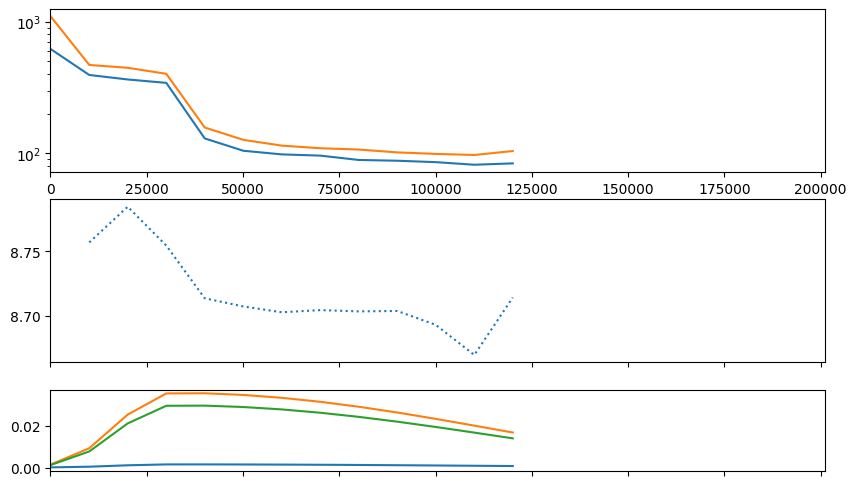

In [ ]:
# with learned positional embeddings, no out_blocks
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=512, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=1, lr=3e-3, warmup_steps=1000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6290 1


'Entropy: 8.70'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 6290 batches x 32 samples, 1307.9 hours) was reported to be 6290 (when accessing len(dataloader)), but 6291 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


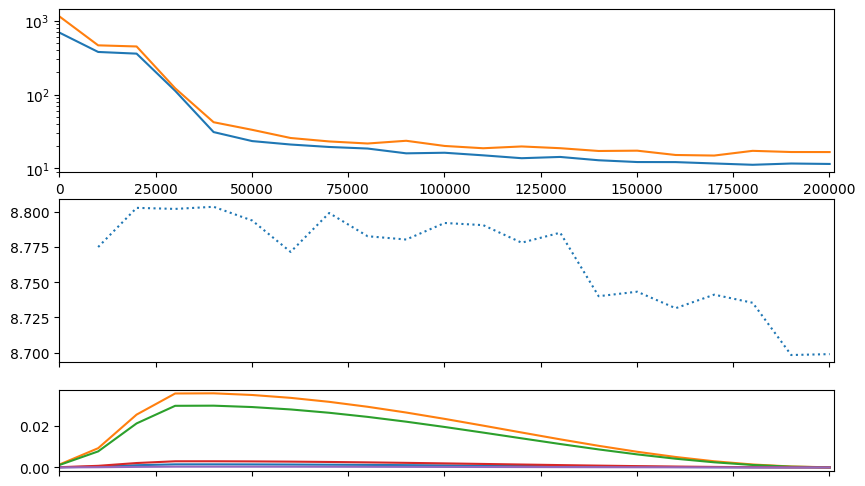

In [ ]:
# with learned positional embeddings, out_blocks before positional
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=512, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=1, lr=3e-3, warmup_steps=1000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6290 1


'Entropy: 8.57'

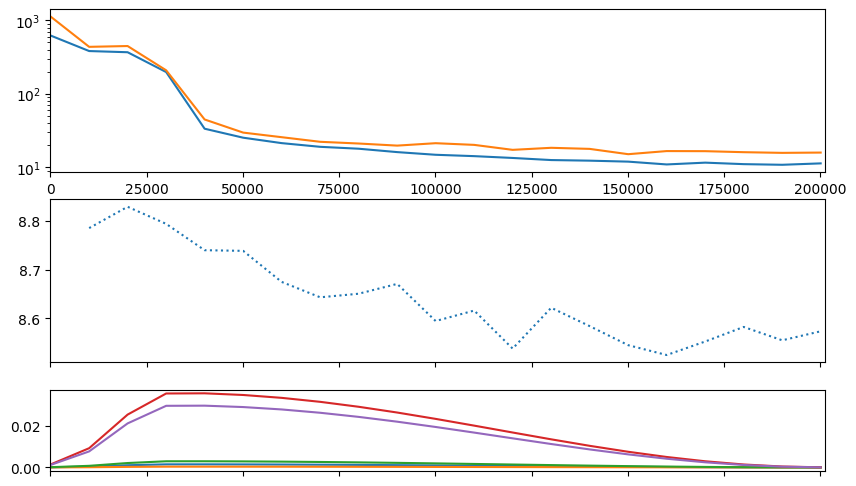

In [ ]:
# with learned positional embeddings, out_blocks before positional, mlp before vq
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=512, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=1, lr=3e-3, warmup_steps=1000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6290 1


'Entropy: 8.54'

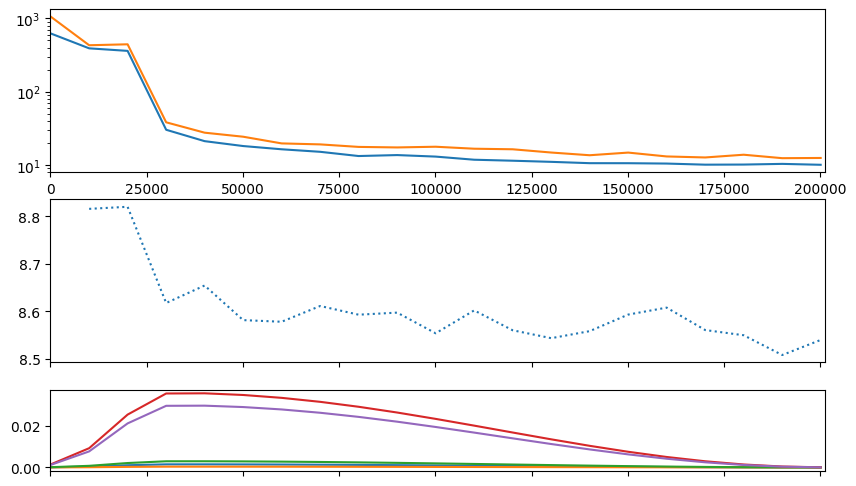

In [ ]:
# with learned positional embeddings, out_blocks after positional, mlp before vq
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=512, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=1, lr=3e-3, warmup_steps=1000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6290 5


'Entropy: 8.40'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 11 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 12 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn

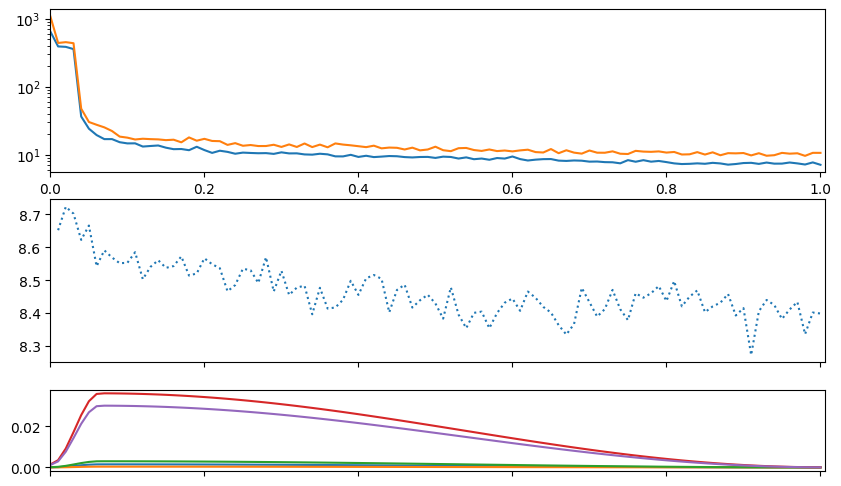

In [ ]:
# with learned positional embeddings, out_blocks after positional, mlp before vq
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=512, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-2d-512c-cosine-padfix-premlp-learnpos-5e.model')

OneCycle: 6290 5


'Entropy: 11.07'

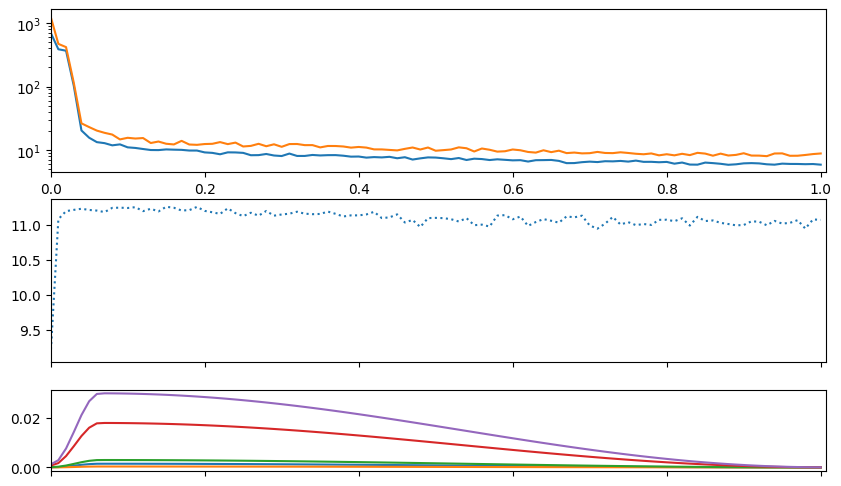

In [ ]:
# with learned positional embeddings, out_blocks after positional, mlp before vq
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=6, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True).cuda()
train("svq", vqmodel, train_ds, val_ds, bs=32, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model')

OneCycle: 6280 5


'Entropy: 10.86'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 11 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 10 batches x 32 samples, 1.9 hours) was reported to be 10 (when accessing len(dataloader)), but 12 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn

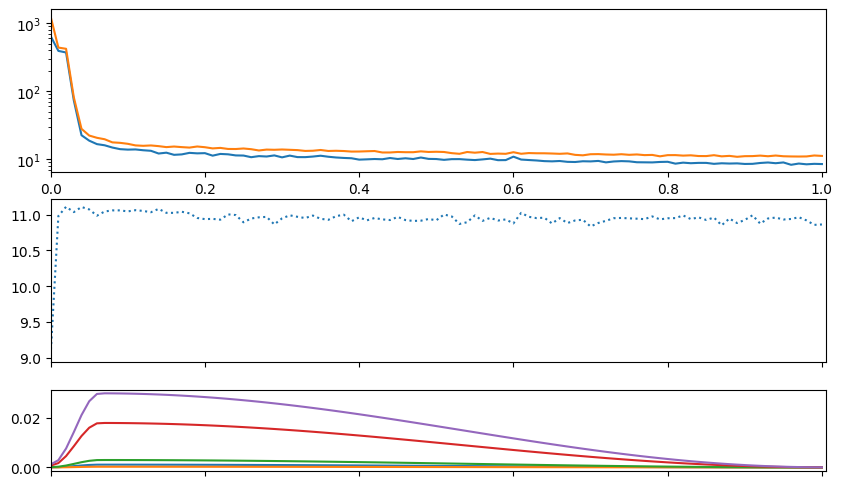

In [ ]:
# base.en Whisper with learned positional embeddings, out_blocks after positional, mlp before vq
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e.model')

OneCycle: 6132 5


'Entropy: 10.79'

/tmp/ipykernel_90303/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_90303/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 6132 batches x 32 samples, 1277.7 hours) was reported to be 6132 (when accessing len(dataloader)), but 6133 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


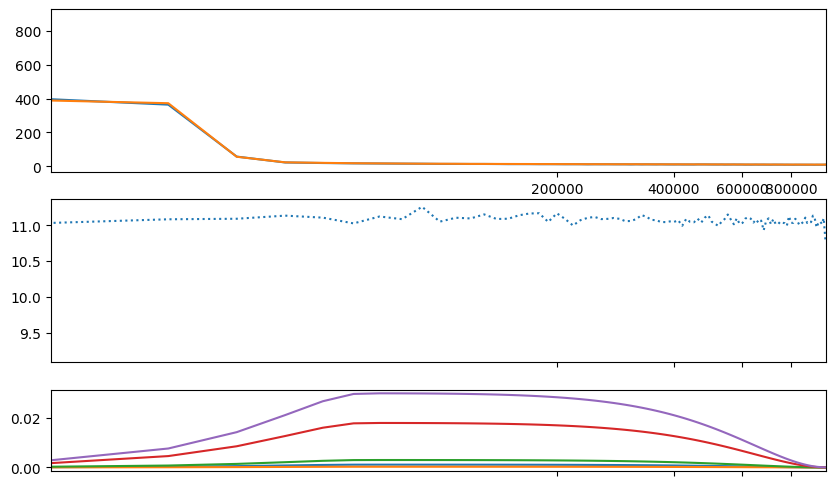

In [ ]:
# base.en whisper with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset (removed 1st and last segments)
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 5


'Entropy: 9.36'

/tmp/ipykernel_90303/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_90303/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


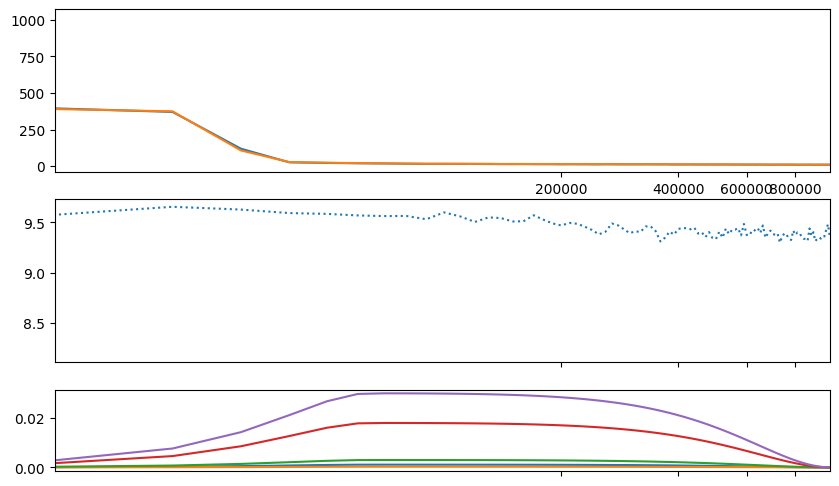

In [ ]:
# base.en whisper with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=1024, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=12, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-1024c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 5


'Entropy: 5.64'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 6132 batches x 32 samples, 1277.7 hours) was reported to be 6132 (when accessing len(dataloader)), but 6133 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


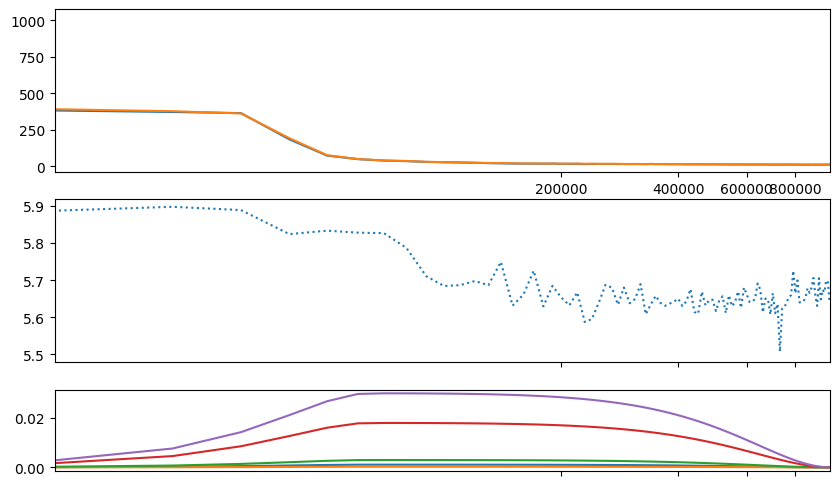

In [ ]:
# base.en whisper with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=64, q_depth=1, n_head=8, depth=1,
                                  downsample=1, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-64c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 5


'Entropy: 8.44'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


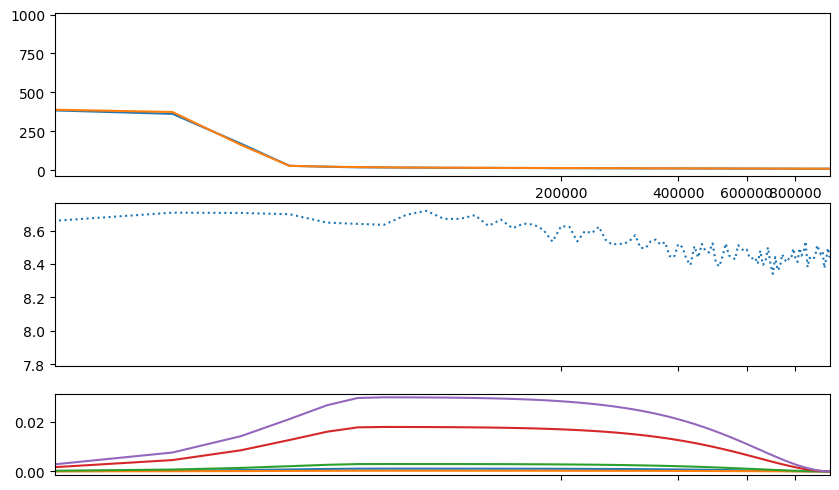

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=512, q_depth=1, n_head=8, depth=1,
                                  downsample=1, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=12, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-512c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 1


'Entropy: 8.55'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


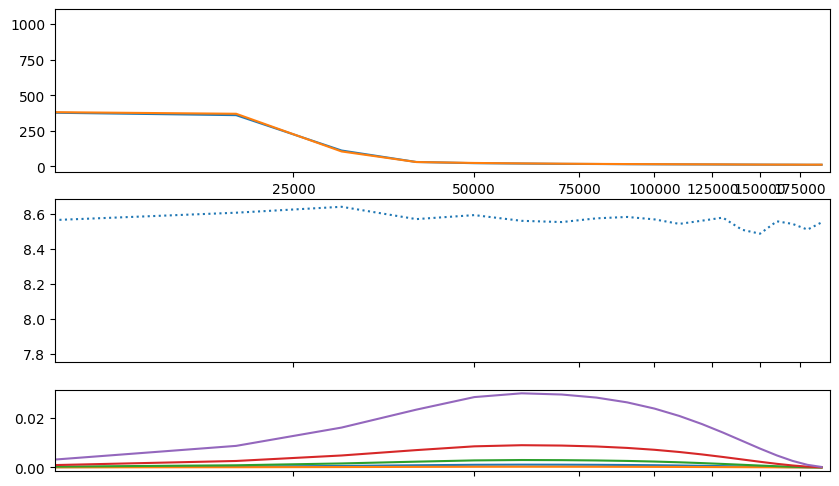

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=64, vq_codes=512, q_depth=1, n_head=8, depth=1,
                                  downsample=1, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6132 1


'Entropy: 11.28'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


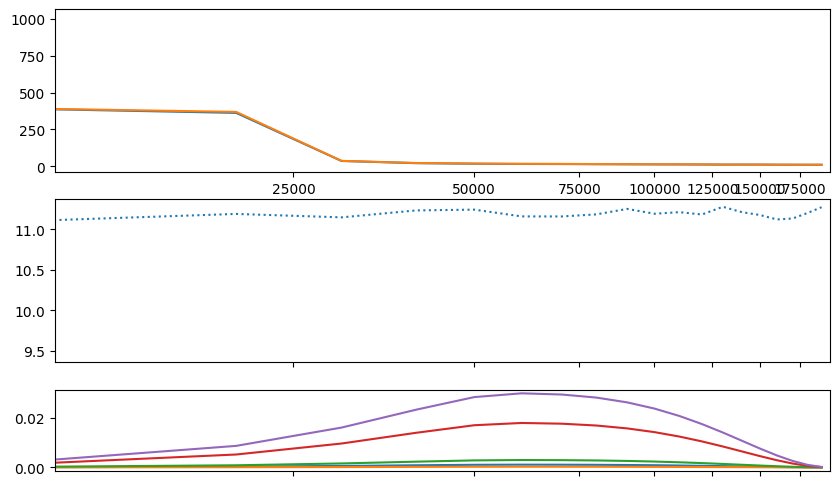

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)

OneCycle: 6132 5


'Entropy: 10.75'

/tmp/ipykernel_100642/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_100642/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



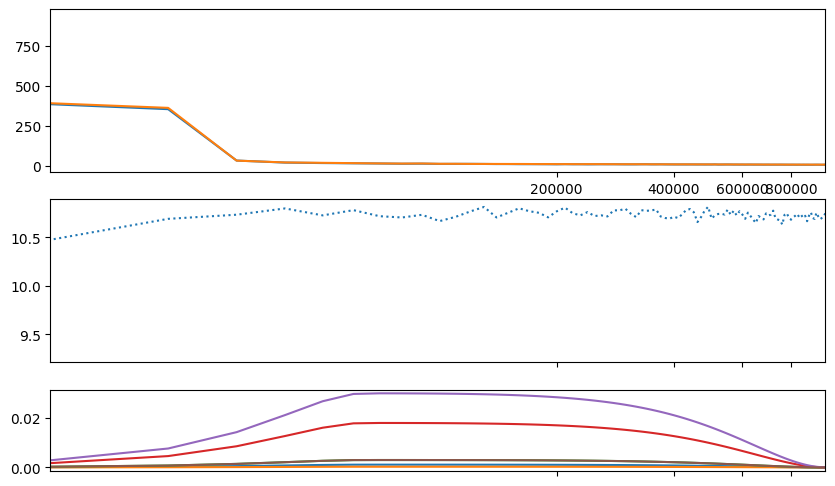

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-preconv-learnpos-5e-cleaned.model')

OneCycle: 6132 5


'Entropy: 10.87'

/tmp/ipykernel_129075/774804256.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_129075/774804256.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 6132 batches x 32 samples, 1277.7 hours) was reported to be 6132 (when accessing len(dataloader)), but 6133 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


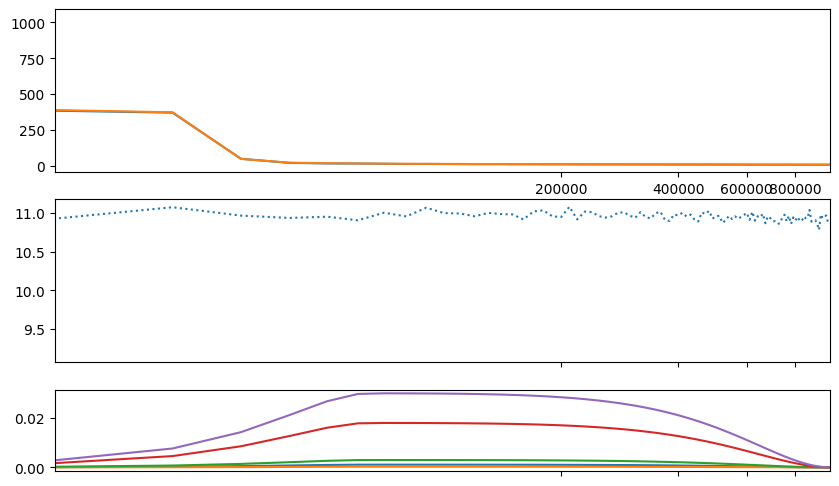

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset, mean downsampling
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned.model')

'Entropy: 10.91'

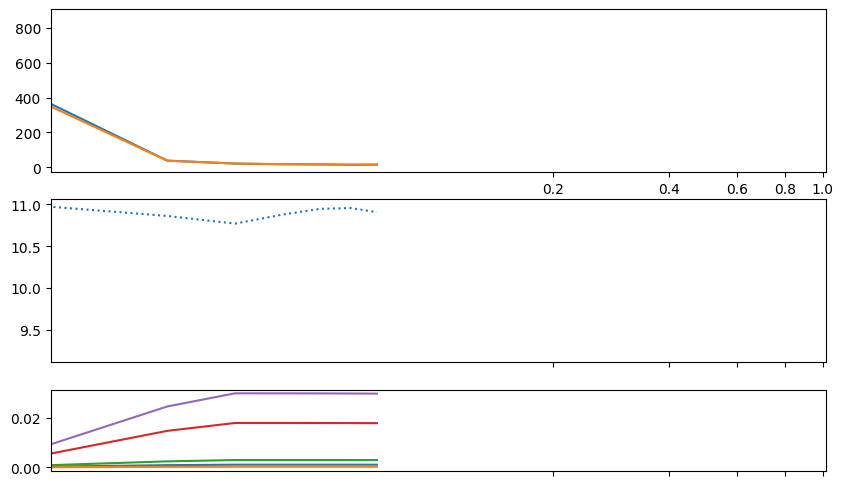

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset, mean downsampling
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
vqmodel.ensure_whisper()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=16, visual_class=RQVisual)

'Entropy: 10.75'

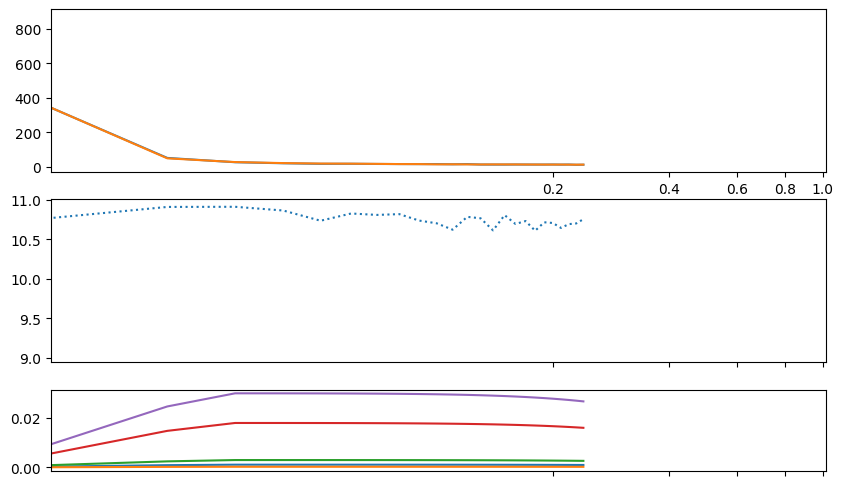

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset, mean downsampling
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
vqmodel.ensure_whisper()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=8, visual_class=RQVisual)
#vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned.model')

OneCycle: 9933 5


'Entropy: 9.83'

/tmp/ipykernel_133489/774804256.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_133489/774804256.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 9933 batches x 32 samples, 1275.0 hours) was reported to be 9933 (when accessing len(dataloader)), but 9934 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


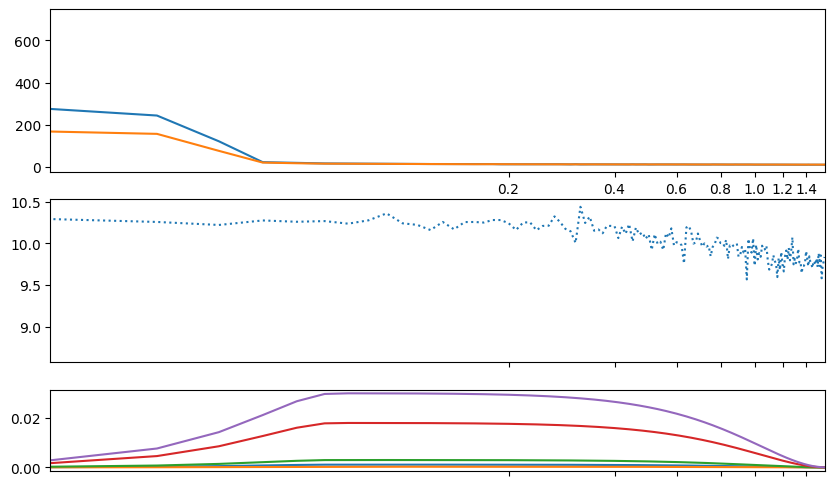

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset, mean downsampling, eqvad
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=5, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
vqmodel.save_model('vq-base.en-2d-4096c-cosine32-padfix-premlp-premean-learnpos-5e-cleaned-eqvad.model')

OneCycle: 6132 1


'Entropy: 10.70'

/tmp/ipykernel_100642/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_100642/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:645: UserWarning: Length of IterableDataset Dataset: 6132 batches x 32 samples, 1277.7 hours) was reported to be 6132 (when accessing len(dataloader)), but 6133 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)


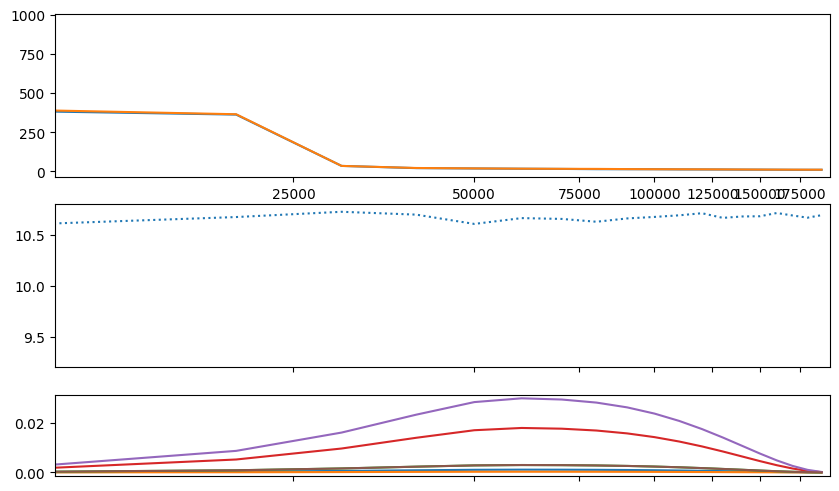

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
# downsample conv
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
#vqmodel.save_model('vq-base.en-512c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 1


'Entropy: 10.14'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


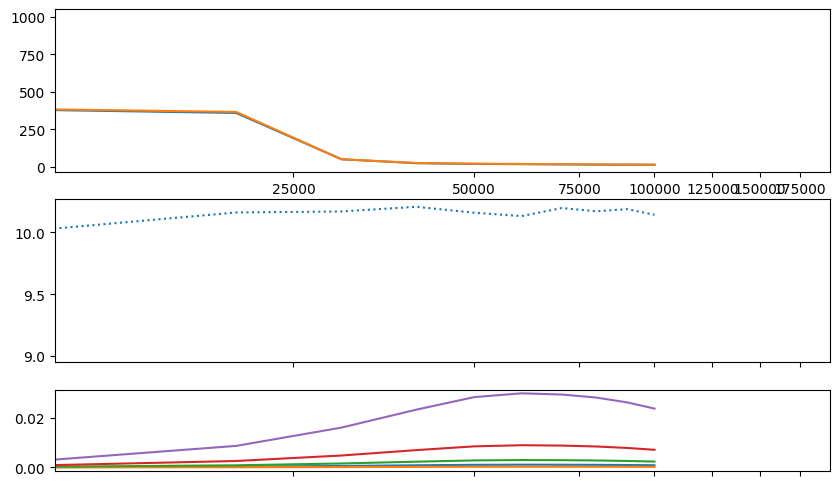

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=64, vq_codes=4096, q_depth=1, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
#vqmodel.save_model('vq-base.en-512c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 1


'Entropy: 11.10'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


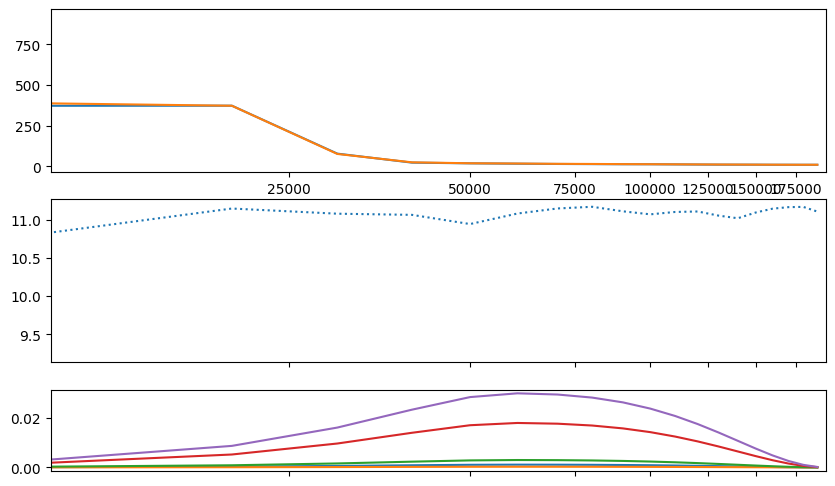

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=4096, q_depth=1, n_head=8, depth=2,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
#vqmodel.save_model('vq-base.en-512c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')

OneCycle: 6132 1


'Entropy: 5.65'

/tmp/ipykernel_94907/1747892456.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.clear()
/tmp/ipykernel_94907/1747892456.py:46: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  loss_p.set_xlim(10000, self.total_steps)


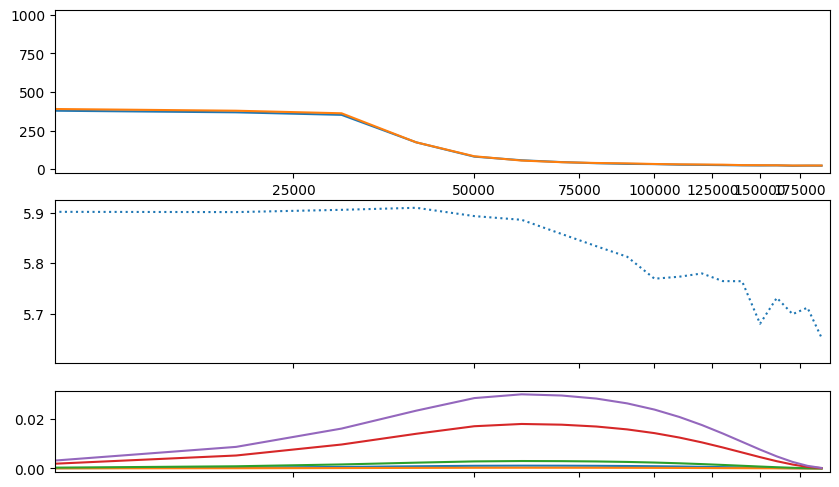

In [ ]:
# base.en! with learned positional embeddings, out_blocks after positional, mlp before vq
# cleaned dataset
vqmodel = RQBottleneckTransformer(codebook_dim=32, vq_codes=64, q_depth=2, n_head=8, depth=1,
                                  downsample=2, threshold_ema_dead_code=0, use_cosine_sim=True, whisper_model_name="base.en").cuda()
train("svq", vqmodel, train_ds, val_ds, bs=14, epochs=1, lr=3e-3, warmup_steps=2000,
      run_valid_every_iters=10000, table_row_every_iters=50000, dl_workers=4, visual_class=RQVisual)
#vqmodel.save_model('vq-base.en-512c-cosine32-padfix-premlp-learnpos-5e-cleaned.model')